In [1]:
from scipy.io import netcdf
import numpy
import netCDF4
import pandas
import aacgmv2
import xarray
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter, MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
from davitpy import utils
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ampFName = "../data/20110516.0000.86400.120.north.grd.ncdf"
startDate = datetime.datetime( 2011, 5, 16, 8, 0 )
selDate = datetime.datetime( 2011, 5, 16, 8, 20 )
endDate = datetime.datetime( 2011, 5, 16, 9, 0 )
delTime = datetime.timedelta(minutes=4)
coords = "mlt"

In [3]:
dsXarr = xarray.open_dataset(ampFName)
ampDF = dsXarr.to_dataframe()
ampDF["start_date"] = pandas.to_datetime( dict(year=ampDF.start_yr,\
                    month=ampDF.start_mo, day=ampDF.start_dy,\
                    hour=ampDF.start_hr, minute=ampDF.start_mt,\
                    second=ampDF.start_sc))
ampDF["end_date"] = pandas.to_datetime( dict(year=ampDF.end_yr,\
                    month=ampDF.end_mo, day=ampDF.end_dy,\
                    hour=ampDF.end_hr, minute=ampDF.end_mt,\
                    second=ampDF.end_sc))
ampDF["mlat"] = 90. - ampDF["colat"]
selCols = ['start_date', 'end_date', 'mlat',\
           'mlt', 'dBnorth1', 'dBeast1',\
       'dBnorth2', 'dBeast2', 'dBr', 'Jr']
ampDF = ampDF[selCols].reset_index(drop=True)

ampDF.head()

,start_date,end_date,mlat,mlt,dBnorth1,dBeast1,dBnorth2,dBeast2,dBr,Jr
0,2011-05-16,2011-05-16 00:10:00,89.0,0.0,82.529999,60.080002,76.720001,67.349998,-2.50,-0.21
1,2011-05-16,2011-05-16 00:10:00,88.0,0.0,80.660004,31.370001,76.199997,41.020000,-2.55,-0.27
2,2011-05-16,2011-05-16 00:10:00,87.0,0.0,61.980000,1.050000,61.169998,10.080000,4.62,-0.28
3,2011-05-16,2011-05-16 00:10:00,86.0,0.0,32.880001,-19.570000,35.610001,-13.990000,13.99,-0.25
4,2011-05-16,2011-05-16 00:10:00,85.0,0.0,9.180000,-25.520000,13.440000,-23.559999,22.02,-0.18


(50, 70)

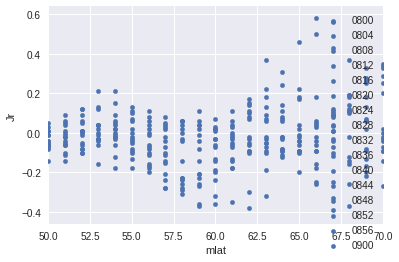

In [4]:


fig1 = plt.figure()
ax = fig1.add_subplot(111)
selMlt = 22.
currDate = startDate
while currDate <= endDate:
    selDF = ampDF[ ((ampDF["start_date"] == currDate) &\
                    (ampDF["mlt"] == selMlt)) & (numpy.abs(ampDF["Jr"])>=0.) ]
    selDF.plot( x="mlat", y="Jr", ax=ax,label=currDate.strftime("%H%M"), kind="scatter")
    currDate += delTime
ax.set_xlim([50,70])
# ax.set_ylim([-0.5,0.5])

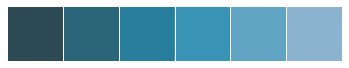

In [5]:
sns.palplot(sns.color_palette("PuBuGn_d"))

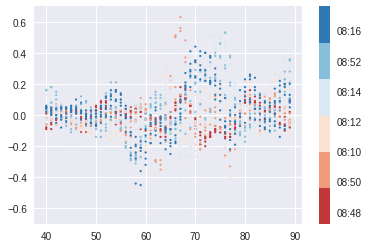

In [6]:
seaMap = ListedColormap(sns.color_palette("RdBu"))
selMlt = 22.

fig = plt.figure()
ax = fig.add_subplot(111)

selDF = ampDF[ ((ampDF["start_date"] >= startDate) & (ampDF["start_date"] <= endDate) &\
                    (ampDF["mlt"] == selMlt) & (numpy.abs(ampDF["Jr"])>=0.)) ]

smap = ax.scatter(selDF['mlat'],selDF['Jr'],s=5,c=selDF['start_date'],
                  edgecolors='none', marker='o', cmap=seaMap) 
cb = fig.colorbar(smap, orientation='vertical')
cb.ax.set_yticklabels(set([ x.strftime('%H:%M') for x in selDF['start_date'] ]))

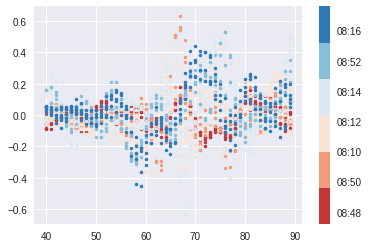

In [7]:
indices = np.linspace(0, seaMap.N, len(selDF))
my_colors = [seaMap(int(i)) for i in indices]

fig, ax = plt.subplots()
for i, idx in enumerate(selDF.index):
    ax.plot(selDF.loc[idx, 'mlat'], selDF.loc[idx, 'Jr'], '.', color=my_colors[i])
cb = fig.colorbar(smap, orientation='vertical')
cb.ax.set_yticklabels(set([ x.strftime('%H:%M') for x in selDF['start_date'] ]))

In [8]:
print set([ x.strftime('%H:%M') for x in selDF['start_date'] ])

set(['08:48', '08:50', '08:10', '08:12', '08:14', '08:52', '08:16', '08:18', '08:38', '08:58', '08:32', '08:30', '08:36', '08:34', '08:42', '09:00', '08:06', '08:04', '08:02', '08:00', '08:08', '08:28', '08:40', '08:46', '08:44', '08:20', '08:22', '08:24', '08:26', '08:54', '08:56'])
